# Names Analysis & Modeling

In [116]:
import pandas as pd 
import unicodedata 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import re 
import sys 
import os
from collections import Counter

from rich.jupyter import display

sys.path.append(os.path.abspath("..")) 
from collections import Counter 
from core.utils.data_loader import DataLoader
from core.utils.region_mapper import RegionMapper
from core.config.pipeline_config import PipelineConfig

In [47]:
LETTERS = 'abcdefghijklmnopqrstuvwxyz'

In [3]:
config = PipelineConfig(
    paths={
        "root_dir": "../data",
        "data_dir": "../data/dataset",
        "models_dir": "../models",
        "outputs_dir": "../data/processed",
        "logs_dir": "../logs",
        "configs_dir": "../configs",
        "checkpoints_dir": "../checkpoints"
    }
)

loader = DataLoader(config)

def normalize_letters(s):
    """Normalize accents -> ascii, lowercase, keep only a-z."""
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", errors="ignore").decode("utf-8")
    s = s.lower()
    s = re.sub(r"[^a-z]", "", s)
    return s

In [23]:
df = loader.load_csv_complete(config.paths.data_dir / "names_featured.csv")
df['province'] = RegionMapper.clean_province(df['province'])

In [24]:
df.columns

Index(['name', 'sex', 'region', 'words', 'length', 'probable_native',
       'probable_surname', 'identified_name', 'identified_surname',
       'ner_entities', 'ner_tagged', 'annotated', 'identified_category',
       'province'],
      dtype='object')

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
words,6467942.0,2.869578,0.46841,1.0,3.0,3.0,3.0,11.0
length,6467942.0,20.141236,3.796574,0.0,18.0,21.0,23.0,60.0
ner_tagged,5018124.0,0.997939,0.045348,0.0,1.0,1.0,1.0,1.0
annotated,5018124.0,0.997939,0.045348,0.0,1.0,1.0,1.0,1.0


In [30]:
# Group by province and compute counts
word_stats = (
    df.groupby("province")["identified_category"]
    .value_counts(normalize=True)  # get proportions
    .unstack(fill_value=0)          # reshape into columns per word count
)

display(word_stats.head(12))

identified_category,compose,simple
province,,
AUTRES,0.206217,0.793783
BANDUNDU,0.626906,0.373094
BAS-CONGO,0.090813,0.909187
EQUATEUR,0.124238,0.875762
KASAI-OCCIDENTAL,0.261266,0.738734
KASAI-ORIENTAL,0.076224,0.923776
KATANGA,0.180624,0.819376
KINSHASA,0.076792,0.923208
MANIEMA,0.461150,0.538850


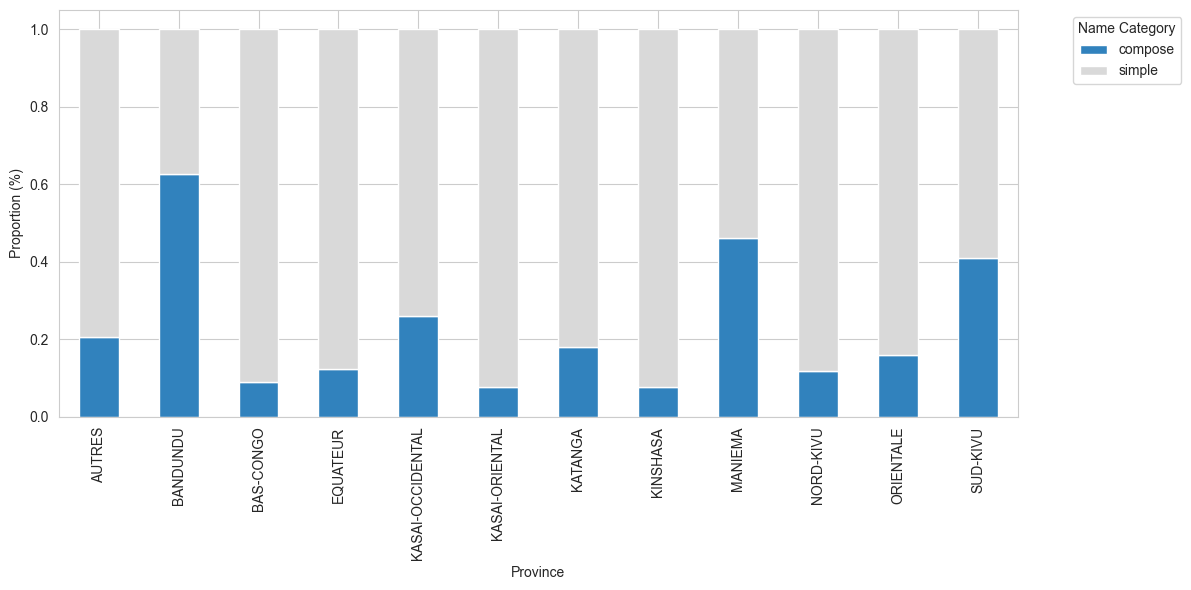

In [33]:
ax = word_stats.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    colormap="tab20c"
)

plt.xlabel("Province")
plt.ylabel("Proportion (%)")
plt.legend(title="Name Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [34]:
# Explode identified_name into words
df_names = (
    df.assign(
        name=(
            df['identified_name']
            .fillna('')
            .str.replace(r"[^\w'\-]+", " ", regex=True)  # keep letters, digits, _, -, '
            .str.strip()
            .str.split()
        )
    )
    .explode('name', ignore_index=True)
    .dropna(subset=['name'])
)

# Clean up tokens
df_names['name'] = df_names['name'].str.strip()
df_names = df_names[df_names['name'].ne('')]

df_names = df_names[['name', 'province', 'sex']].reset_index(drop=True)

In [29]:
df_names.describe().T

,count,unique,top,freq
name,10015595,644336,ilunga,82342
province,10015595,12,KINSHASA,2106077
sex,10015595,2,m,6033856


In [13]:
# Province counts before exploding
prov_counts_orig = (
    df['province'].value_counts()
    .rename_axis("province")
    .reset_index(name="count_original")
)

# Province counts after exploding into df_names
prov_counts_names = (
    df_names['province'].value_counts()
    .rename_axis("province")
    .reset_index(name="count_names")
)

# Merge both into one table
comparison = (
    prov_counts_orig
    .merge(prov_counts_names, on="province", how="outer")
    .fillna(0)
)

# Add augmentation percentage
comparison["augmentation"] = (
        (comparison["count_names"] - comparison["count_original"])
        / comparison["count_original"]
        * 100
).round(2)

# Sort and display top 12 provinces
comparison = (
    comparison
    .sort_values("count_original", ascending=False)
    .reset_index(drop=True)
)

display(comparison.head(12))

,province,count_original,count_names,augmentation
0,KINSHASA,1140620,2106077,84.64
1,AUTRES,1035751,1644326,58.76
2,KATANGA,836220,1370359,63.88
3,BANDUNDU,809949,604374,-25.38
4,KASAI-ORIENTAL,434497,802757,84.76
5,NORD-KIVU,394999,695494,76.07
6,KASAI-OCCIDENTAL,367626,543156,47.75
7,EQUATEUR,356404,624252,75.15
8,SUD-KIVU,346152,408708,18.07
9,ORIENTALE,322756,541646,67.82


## Transition probabilities

In [133]:
def build_transition_probs(
        names: pd.Series,
        *,
        letters: str = "abcdefghijklmnopqrstuvwxyz",
        start_token: str = "^",
        end_token: str = "$",
        alpha: float = 0.0,  # Laplace smoothing; e.g., 1.0 to avoid zeros
) -> dict:
    # 1) Normalize
    names = (
        names.astype(str)
        .str.lower()
        .str.replace(fr"[^{letters}]", "", regex=True)
    )
    names = names[names.str.len() > 0]

    # 2) Prepare sequences
    sequences = (start_token + names + end_token).tolist()

    # 3) Tokens and indices
    tokens = [start_token] + list(letters) + [end_token]
    index = {t: i for i, t in enumerate(tokens)}
    V = len(tokens)

    # 4) ASCII lookup table (O(1) char -> idx); others -> -1
    lut = np.full(128, -1, dtype=np.int32)
    for ch, i in index.items():
        lut[ord(ch)] = i

    # 5) Concatenate with a separator that’s not in vocab to kill cross-boundary pairs
    concat = (" ".join(sequences)).encode("ascii", errors="ignore")

    # 6) Map bytes to indices
    arr = np.frombuffer(concat, dtype=np.uint8)
    idx = lut[arr]

    # 7) Build bigram pairs; drop invalid ones (separator & OOV)
    a = idx[:-1]
    b = idx[1:]
    mask = (a >= 0) & (b >= 0)
    a, b = a[mask], b[mask]

    # 8) Count with a single bincount
    lin = a * V + b
    counts = np.bincount(lin, minlength=V * V).reshape(V, V)

    # 9) Optional Laplace smoothing
    if alpha and alpha > 0:
        counts = counts + alpha

    # 10) Row-normalize to probabilities
    row_sums = counts.sum(axis=1, keepdims=True)
    # avoid division by zero
    probs = np.divide(counts, np.where(row_sums == 0, 1.0, row_sums), where=True)

    # 11) DataFrames
    df_counts = pd.DataFrame(counts, index=tokens, columns=tokens)
    df_probs  = pd.DataFrame(probs, index=tokens, columns=tokens)

    return {
        "tokens": tokens,
        "index": index,
        "counts": counts,
        "df_counts": df_counts,
        "probs": probs,
        "df_probs": df_probs,
    }


In [134]:
transitions_both   = build_transition_probs(df_names['name'])
transitions_male   = build_transition_probs(df_names.loc[df_names['sex'].str.lower() == 'm', 'name'])
transitions_female = build_transition_probs(df_names.loc[df_names['sex'].str.lower() == 'f', 'name'])

# Access the probability matrices
P_both   = transitions_both['probs']
P_male   = transitions_male['probs']
P_female = transitions_female['probs']

In [85]:
P_both

array([[0.00000000e+00, 3.24013508e-02, 9.26023186e-02, 8.07567504e-03,
        1.78577669e-02, 2.02887868e-02, 8.45799629e-03, 5.69657652e-03,
        3.69820166e-03, 2.68854009e-02, 3.07494515e-03, 1.88787613e-01,
        6.02969225e-02, 2.67433060e-01, 1.19960803e-01, 1.46038926e-02,
        1.25087642e-02, 9.48564064e-06, 5.46732357e-03, 3.25790818e-02,
        4.21499933e-02, 4.79364338e-03, 5.06603104e-03, 1.06228192e-02,
        8.28745445e-06, 1.07286590e-02, 5.94460106e-03, 0.00000000e+00],
       [0.00000000e+00, 9.79188615e-04, 4.85819282e-02, 2.02181039e-03,
        2.09905376e-02, 1.13126896e-03, 6.78761374e-03, 6.18601611e-03,
        1.18322753e-02, 4.85108866e-03, 3.21792803e-03, 4.38667298e-02,
        7.63473398e-02, 8.29327106e-02, 1.35175537e-01, 1.80842017e-03,
        1.14416792e-02, 6.45832751e-06, 1.04753187e-02, 4.64873953e-02,
        3.37630746e-02, 4.56718766e-03, 1.12748243e-02, 8.25896230e-03,
        1.62785241e-05, 3.24132841e-02, 1.16528576e-02, 3.82932

In [86]:
P_male

array([[0.00000000e+00, 2.96327947e-02, 9.45715253e-02, 8.33096048e-03,
        1.81781176e-02, 2.09494693e-02, 5.91876912e-03, 6.34754052e-03,
        4.11468069e-03, 2.87384574e-02, 3.65044075e-03, 1.93122652e-01,
        6.22444484e-02, 2.67734512e-01, 1.12960631e-01, 1.50441252e-02,
        1.26316023e-02, 8.45277995e-06, 5.48303660e-03, 3.08622598e-02,
        4.36282779e-02, 5.04415500e-03, 4.43572059e-03, 1.08358009e-02,
        1.17675956e-05, 1.04719999e-02, 5.04780130e-03, 0.00000000e+00],
       [0.00000000e+00, 1.07774382e-03, 5.15268406e-02, 1.87845051e-03,
        2.15718500e-02, 1.25913894e-03, 6.20846565e-03, 6.55930063e-03,
        8.54962869e-03, 4.40750288e-03, 2.91914781e-03, 4.46714630e-02,
        8.15416076e-02, 8.72904602e-02, 1.38306915e-01, 1.79269741e-03,
        1.07895411e-02, 6.93699804e-06, 1.04567128e-02, 4.69147701e-02,
        3.34081398e-02, 4.53517316e-03, 6.95810422e-03, 7.63010746e-03,
        2.19917597e-05, 3.33792110e-02, 1.20914828e-02, 3.74246

In [87]:
P_female

array([[0.00000000e+00, 3.65966617e-02, 8.96182961e-02, 7.68883017e-03,
        1.73723258e-02, 1.92876266e-02, 1.23057951e-02, 4.71014311e-03,
        3.06709329e-03, 2.40773856e-02, 2.20287220e-03, 1.82218544e-01,
        5.73457537e-02, 2.66976256e-01, 1.30568462e-01, 1.39367895e-02,
        1.23226225e-02, 1.10507783e-05, 5.44351294e-03, 3.51806551e-02,
        3.99098859e-02, 4.41403248e-03, 6.02116726e-03, 1.03000789e-02,
        3.01384863e-06, 1.11175853e-02, 7.30355986e-03, 0.00000000e+00],
       [0.00000000e+00, 8.31719108e-04, 4.41754154e-02, 2.23632174e-03,
        2.01207119e-02, 9.39935349e-04, 7.65420097e-03, 5.62746537e-03,
        1.67441443e-02, 5.51483214e-03, 3.66499697e-03, 4.26625966e-02,
        6.85750858e-02, 7.64121502e-02, 1.30490014e-01, 1.83194636e-03,
        1.24174824e-02, 5.74208625e-06, 1.05031591e-02, 4.58479085e-02,
        3.42941684e-02, 4.61509140e-03, 1.77339917e-02, 9.19992641e-03,
        7.72973148e-06, 3.09679545e-02, 1.09965369e-02, 3.95928

In [135]:
def plot_transition_matrix(ax, df_probs, title="", letters="abcdefghijklmnopqrstuvwxyz"):
    hm = sns.heatmap(
        df_probs.loc[list(letters), list(letters)],
        cmap="Reds",
        annot=False,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=12)
    return hm

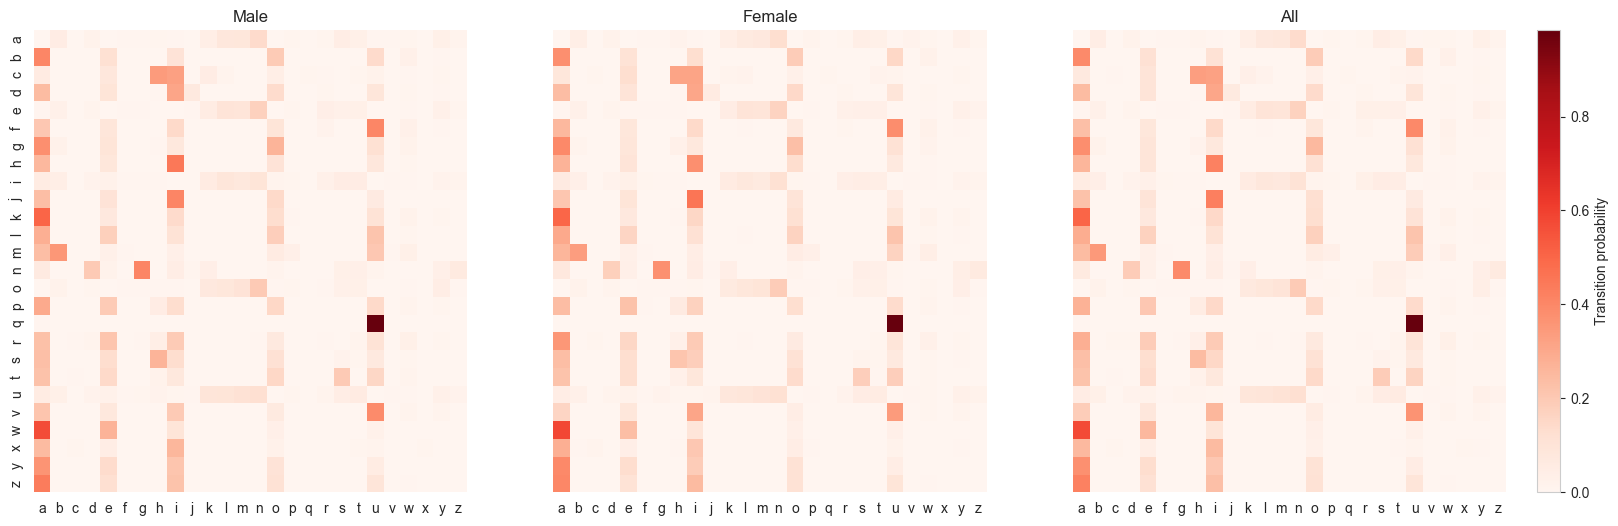

In [136]:
# Create 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

hm1 = plot_transition_matrix(axes[0], transitions_male['df_probs'],   "Male")
hm2 = plot_transition_matrix(axes[1], transitions_female['df_probs'], "Female")
hm3 = plot_transition_matrix(axes[2], transitions_both['df_probs'],   "All")

# Add one shared colorbar
cbar = fig.colorbar(hm3.collections[0], ax=axes, orientation="vertical", fraction=0.03, pad=0.02)
cbar.set_label("Transition probability")

plt.show()

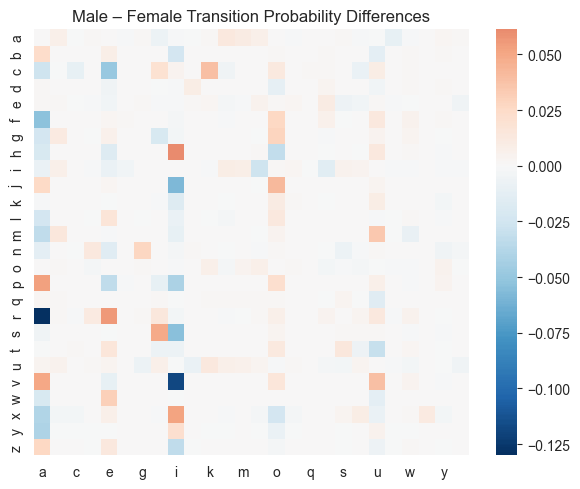

In [142]:
diff = transitions_male['df_probs'] - transitions_female['df_probs']

plt.figure(figsize=(6, 5))
sns.heatmap(diff.loc[list(LETTERS), list(LETTERS)], cmap="RdBu_r", center=0, annot=False)
plt.title("Male – Female Transition Probability Differences")
plt.tight_layout()
plt.show()

In [117]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import entropy

P_m = transitions_male['probs'].flatten()
P_f = transitions_female['probs'].flatten()

# L2 distance
l2 = euclidean(P_m, P_f)

# KL divergence (use smoothing to avoid log(0))
kl_mf = entropy(P_m + 1e-12, P_f + 1e-12)  # D_KL(male || female)
kl_fm = entropy(P_f + 1e-12, P_m + 1e-12)

# Symmetric Jensen-Shannon divergence
jsd = 0.5 * (kl_mf + kl_fm)

print(f"L2 distance: {l2:.4f}")
print(f"KL(male||female): {kl_mf:.4f}")
print(f"KL(female||male): {kl_fm:.4f}")
print(f"JSD: {jsd:.4f}")


L2 distance: 0.3189
KL(male||female): 0.0432
KL(female||male): 0.0215
JSD: 0.0324


The transition probabilities of characters in male and female names from your dataset are very similar. There are measurable but small differences: male names diverge slightly more from the female pattern than the reverse. However, the overall structure of how characters follow each other is largely shared between the two groups.

In [153]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def chi2_row_test(trans_male, trans_female, row_token, alpha=0.5, min_expected=1e-12):
    """
    Chi-square test comparing next-letter distributions for a given starting letter.
    Handles zeros by dropping all-zero columns and adding pseudocount alpha.

    Args:
        trans_male, trans_female: dicts returned by build_transition_probs (need 'counts','index','tokens')
        row_token: e.g., 'a'
        alpha: pseudocount added to every cell (0.5 is common; set 0 to disable)
        min_expected: tiny floor to avoid expected==0 after drop (defensive)
    """
    i_m = trans_male['index'][row_token]
    i_f = trans_female['index'][row_token]
    cm = trans_male['counts'][i_m].astype(float)
    cf = trans_female['counts'][i_f].astype(float)

    # Stack into 2xK
    table = np.vstack([cm, cf])

    # Drop columns with zero total across both groups
    keep = table.sum(axis=0) > 0
    table = table[:, keep]

    # If everything got dropped or only 1 column left, test is undefined
    if table.size == 0 or table.shape[1] < 2:
        return np.nan, np.nan, 0, None

    # Add pseudocounts (helps with sparsity and zero expected)
    if alpha and alpha > 0:
        table = table + alpha

    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    # Defensive floor (optional)
    if np.any(expected < min_expected):
        # fall back: jitter + rerun (very rare)
        table = table + 1e-9
        chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return chi2, p, dof, expected

# Example: a single row
chi2, p, dof, expected = chi2_row_test(transitions_male, transitions_female, row_token='a', alpha=0.5)
print(f"Row 'a' → χ²={chi2:.3f}, dof={dof}, p={p:.3e}")

# Run for all letters and assemble a summary (with FDR correction)
from statsmodels.stats.multitest import multipletests

tokens = [t for t in transitions_both['tokens'] if t not in ('^','$')]
results = []
for t in tokens:
    chi2, p, dof, _ = chi2_row_test(transitions_male, transitions_female, row_token=t, alpha=0.5)
    results.append((t, chi2, dof, p))

df_tests = pd.DataFrame(results, columns=['row_token','chi2','dof','p'])
# FDR (Benjamini–Hochberg)
mask = df_tests['p'].notna()
rej, p_adj, _, _ = multipletests(df_tests.loc[mask, 'p'], method='fdr_bh')
df_tests.loc[mask, 'p_adj'] = p_adj
df_tests.loc[mask, 'significant'] = rej

df_tests = df_tests.sort_values('chi2', ascending=False).reset_index(drop=True)

Row 'a' → χ²=66636.402, dof=26, p=0.000e+00


In [155]:
df_tests.head(7)

,row_token,chi2,dof,p,p_adj,significant
0,a,66636.401639,26,0.0,0.0,True
1,i,36497.202246,26,0.0,0.0,True
2,n,32505.512092,25,0.0,0.0,True
3,u,31904.897504,26,0.0,0.0,True
4,g,24595.637377,26,0.0,0.0,True
5,m,23254.272134,26,0.0,0.0,True
6,e,19945.183545,26,0.0,0.0,True


Male and female names in your dataset have very similar character transition patterns overall (global JSD ≈ 0.03),
But for certain letters — especially a, i, n, u, g, m, e — the differences are statistically huge.
These letters likely correspond to prefixes or suffixes that carry strong gender information in local naming traditions.

## Letters frequency

In [159]:
def letter_freq(df: pd.DataFrame, col: str = "name") -> pd.DataFrame:
    s = (
        df[col].astype(str).str.lower()
        .str.replace(r'[^a-z]', '', regex=True)  # keep only a–z
        .str.cat(sep='')                         # one big string
    )
    ser = pd.Series(list(s))
    out = (
        ser.value_counts(normalize=False)
        .reindex(list(LETTERS), fill_value=0)
        .rename_axis("letter").reset_index(name="count")
    )
    total = out["count"].sum()
    out["freq"] = out["count"] / (total if total > 0 else 1)
    return out


In [167]:
def plot_letter_grid(df_all: pd.DataFrame, use="freq", sort_values=False):
    """
    Plot a 1×3 grid of letter distributions for Male, Female, and Both.
    `use` ∈ {"freq","count"} controls y-axis.
    """
    # Slice datasets (adapt values if your labels are 'M'/'F', etc.)
    df_male   = df_all[df_all['sex'].str.lower() == str('m').lower()]
    df_female = df_all[df_all['sex'].str.lower() == str('f').lower()]
    df_both   = df_all

    L_m = letter_freq(df_male,   col='name')
    L_f = letter_freq(df_female, col='name')
    L_b = letter_freq(df_both,   col='name')

    y = "freq" if use == "freq" else "count"
    if sort_values:
        L_m = L_m.sort_values(y, ascending=False)
        L_f = L_f.sort_values(y, ascending=False)
        L_b = L_b.sort_values(y, ascending=False)

    ymax = max(L_m[y].max(), L_f[y].max(), L_b[y].max()) * 1.10

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, constrained_layout=True)
    for ax, data, title in zip(axes, [L_m, L_f, L_b], ["Male", "Female", "All"]):
        ax.bar(data["letter"], data[y], color="steelblue", alpha=0.8)
        ax.set_title(title)
        ax.set_xlabel("Letter")
        ax.set_ylim(0, ymax)
        ax.grid(axis="y", alpha=0.3)
    axes[0].set_ylabel("Frequency" if y == "freq" else "Count")
    plt.show()

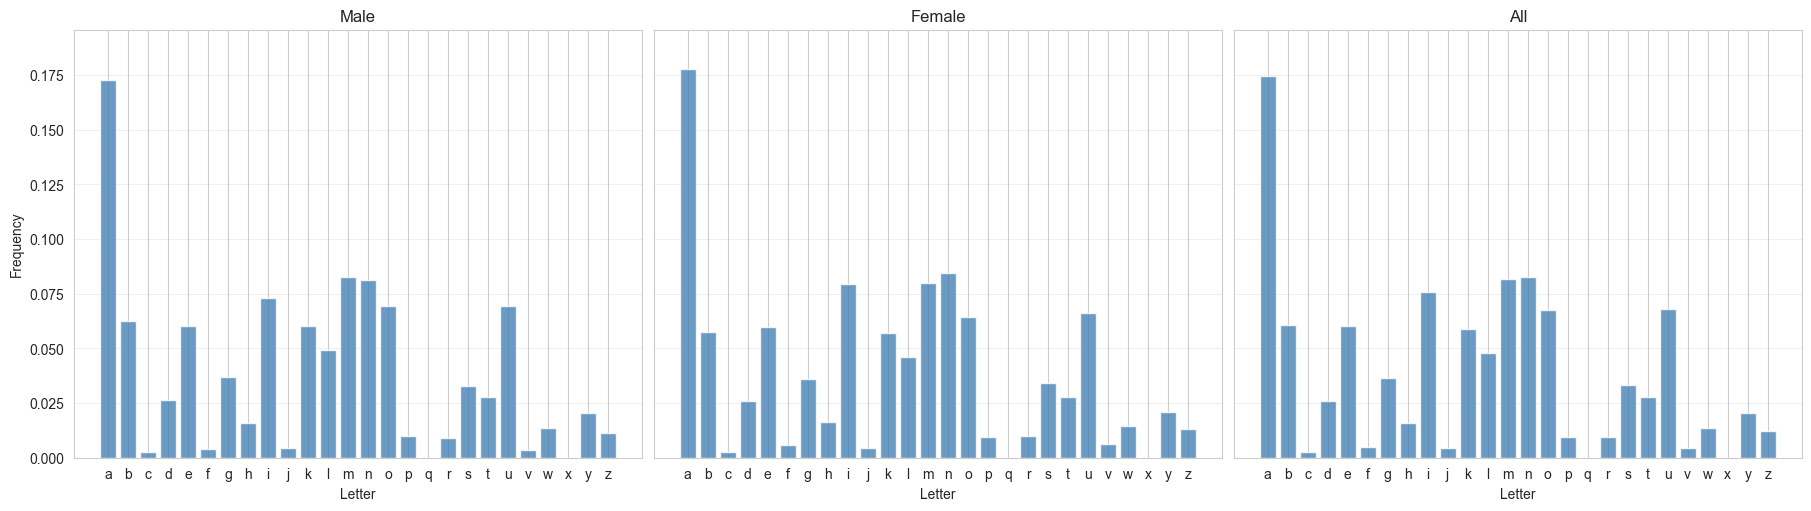

In [168]:
plot_letter_grid(df_names, use="freq")

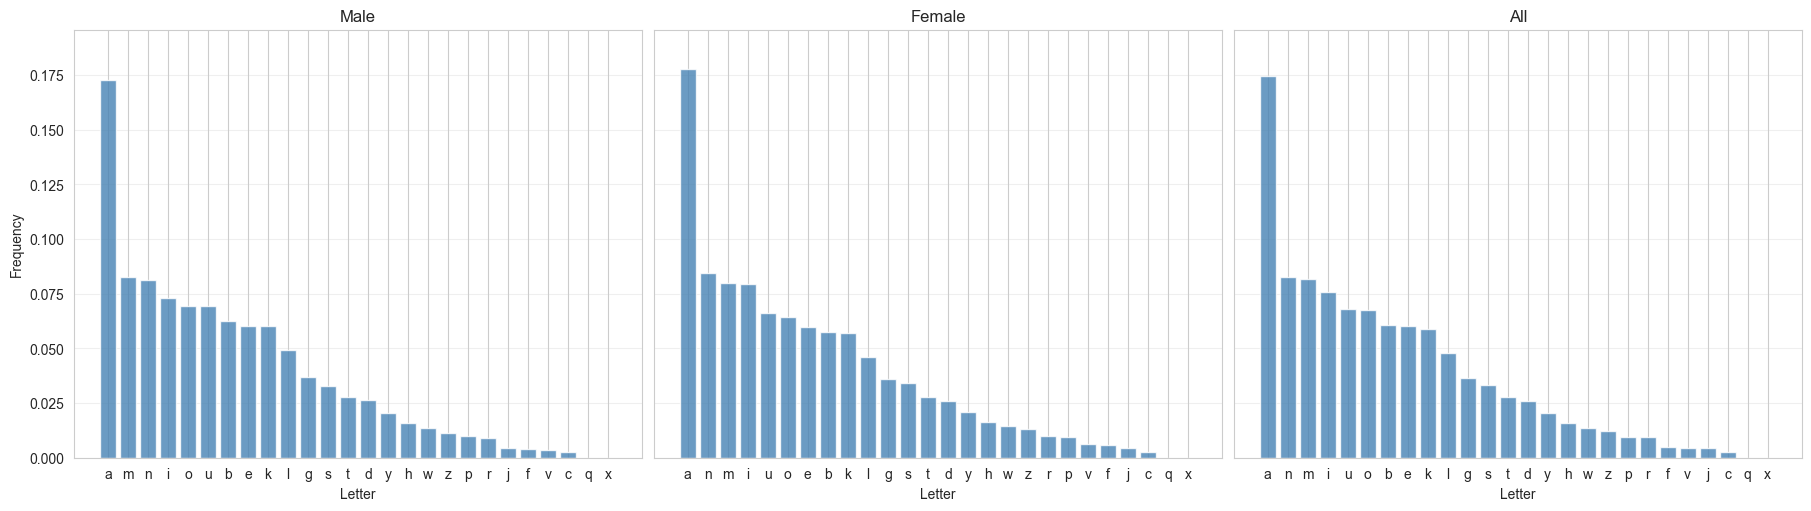

In [169]:
plot_letter_grid(df_names, use="freq", sort_values=True)

In [192]:
def count_ngrams(df: pd.DataFrame, n: int, col: str = "name") -> pd.DataFrame:
    # Normalize and clean
    _names = (
        df[col]
        .astype(str)
        .str.lower()
        .str.replace(r"[^a-z]", "", regex=True)
    )

    # Collect n-grams from all names
    ngrams = []
    for name in _names:
        if len(name) >= n:
            ngrams.extend(name[i:i+n] for i in range(len(name) - n + 1))

    # Count
    counter = Counter(ngrams)

    # Build DataFrame
    df_ngrams = (
        pd.DataFrame(counter.items(), columns=[f"{n}-gram", "count"])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )
    df_ngrams["freq"] = df_ngrams["count"] / df_ngrams["count"].sum()
    return df_ngrams

def plot_ngrams_grid(df: pd.DataFrame, n: int, top_k: int = 20,
                     gender_col="sex", male_value="m", female_value="f", name_col="name"):
    """
    Plot top n-grams for Male, Female, and All in a 1×3 grid.
    """
    # Split datasets
    df_male   = df[df[gender_col].str.lower() == str(male_value).lower()]
    df_female = df[df[gender_col].str.lower() == str(female_value).lower()]
    df_all    = df

    # Compute n-grams
    ng_male   = count_ngrams(df_male, n, col=name_col)
    ng_female = count_ngrams(df_female, n, col=name_col)
    ng_all    = count_ngrams(df_all, n, col=name_col)

    # Plot in a grid
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True, constrained_layout=True)
    for ax, data, title in zip(
            axes, [ng_male, ng_female, ng_all], ["Male", "Female", "All"]
    ):
        sns.barplot(
            data=data.head(top_k),
            x=f"{n}-gram", y="count",
            ax=ax
        )
        ax.set_title(f"{title} – Top {top_k} {n}-grams")
        ax.set_xlabel(f"{n}-gram")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=45)

    plt.show()

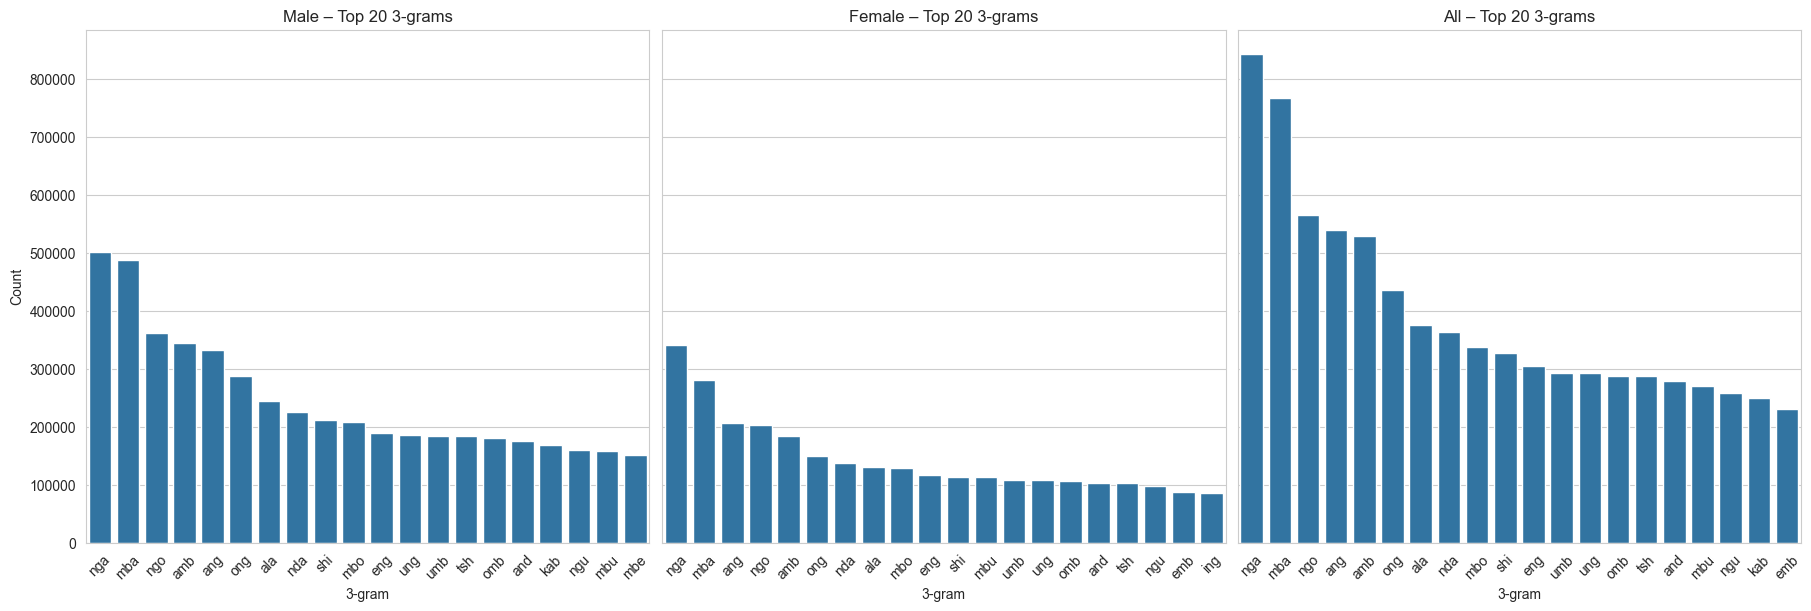

In [193]:
plot_ngrams_grid(df_names, n=3, top_k=20, gender_col="sex")

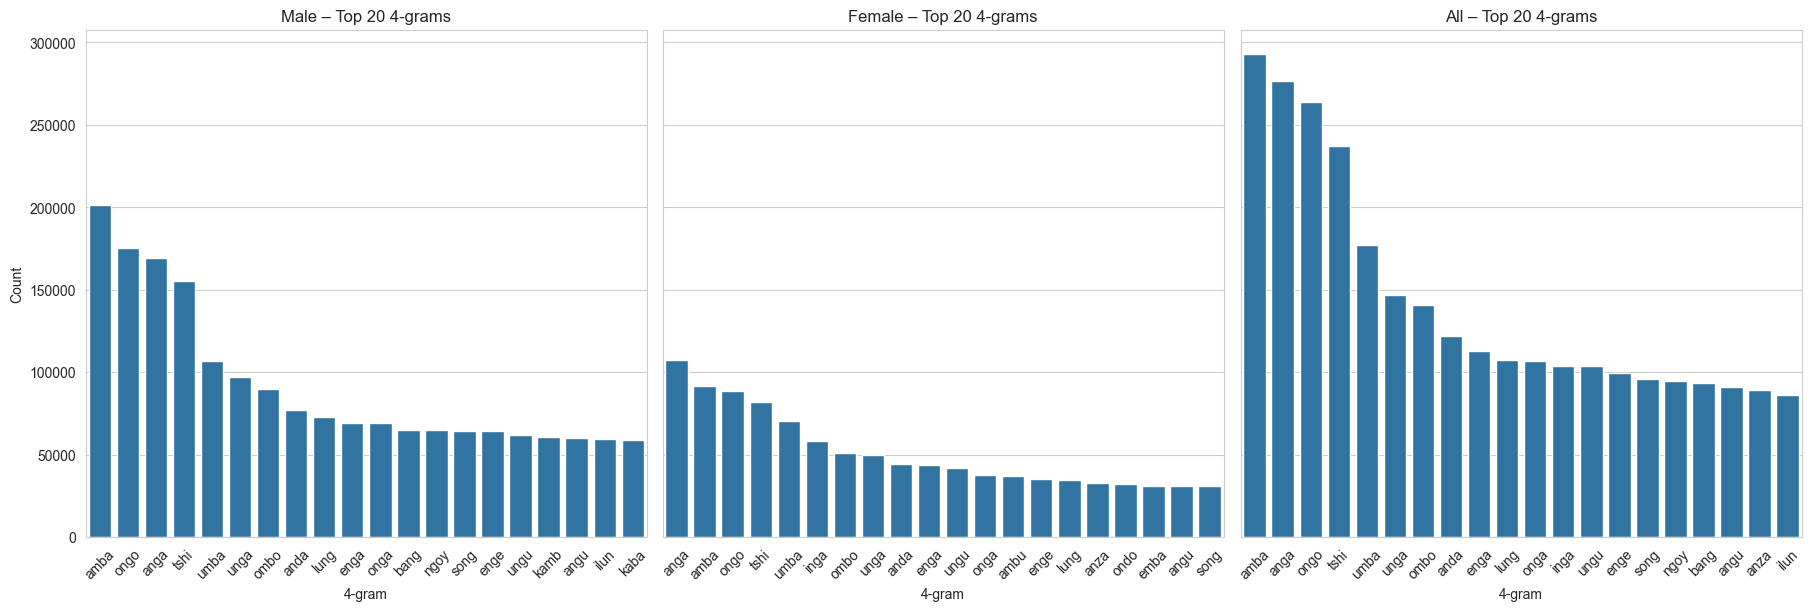

In [194]:
plot_ngrams_grid(df_names, n=4, top_k=20, gender_col="sex")

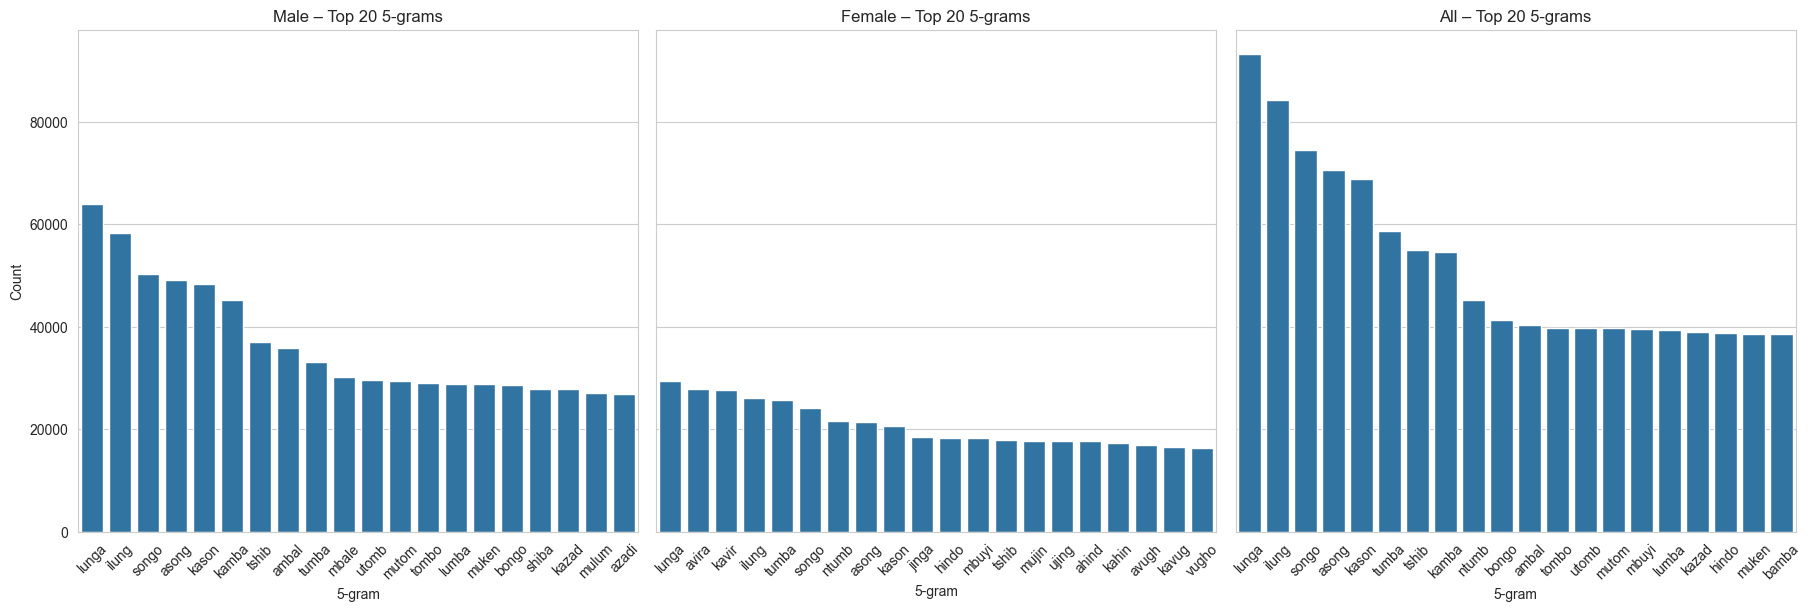

In [195]:
plot_ngrams_grid(df_names, n=5, top_k=20, gender_col="sex")

## Name generation

In [73]:
# tokens must include '^' (start) and '$' (end)
tokens = ["^"] + list(LETTERS) + ["$"]
token_to_idx = {t: i for i, t in enumerate(tokens)}
idx_to_token = np.array(tokens)
V = len(tokens)

# Prepare a well-formed probability matrix (rows sum to 1, no NaNs/negatives)
def prepare_prob_matrix(df_probs, tokens):
    P = df_probs.loc[tokens, tokens].to_numpy(dtype=float)
    P[~np.isfinite(P) | (P < 0)] = 0.0
    rs = P.sum(axis=1, keepdims=True)
    P = np.divide(P, np.where(rs == 0, 1.0, rs), out=np.zeros_like(P), where=True)
    return P

def generate_name(P, token_to_idx, idx_to_token, *,
                  target_len=None,   # exact character length (letters only), if provided
                  min_len=1,         # minimum character length
                  max_len=12,        # hard cap on steps
                  temperature=1.0):
    start = token_to_idx['^']
    end   = token_to_idx['$']
    cur = start
    out = []

    for _ in range(max_len):
        row = P[cur]

        # Temperature scaling (τ<1 = sharper, τ>1 = flatter)
        if temperature != 1.0:
            row = np.power(row, 1.0 / temperature)
            s = row.sum()
            row = row / s if s > 0 else row

        row_mod = row.copy()

        # 1) Prevent early stop before min_len
        if len(out) < min_len:
            row_mod[end] = 0.0

        # 2) If target_len reached or exceeded, force end
        if target_len is not None and len(out) >= target_len:
            row_mod[:] = 0.0
            row_mod[end] = 1.0

        s = row_mod.sum()
        if s == 0.0:
            # Fallback: uniform over valid next tokens
            candidates = np.arange(V)
            # exclude '^'
            candidates = candidates[candidates != start]
            # exclude '$' if below min_len
            if len(out) < min_len:
                candidates = candidates[candidates != end]
            probs = np.ones(len(candidates)) / len(candidates)
            nxt_idx = np.random.choice(candidates, p=probs)
        else:
            row_mod = row_mod / s
            nxt_idx = np.random.choice(V, p=row_mod)

        if nxt_idx == end:
            break
        out.append(idx_to_token[nxt_idx])
        cur = nxt_idx

    return "".join(out).capitalize()

In [78]:
# Example preparation and usage
P = prepare_prob_matrix(df_probs, tokens)
generated_var = [generate_name(P, token_to_idx, idx_to_token, min_len=5, max_len=12, temperature=0.5) for _ in range(10)]

display(pd.DataFrame(generated_var, columns=["name"]))

,name
0,Mbamba
1,Ngokanga
2,Mimbango
3,Mundo
4,Musona
5,Bonda
6,Kanganga
7,Zandi
8,Vulunda
9,Mbangu
